/var/folders/c5/ybp1wl2s3896gfn80wrxfwm80000gn/T/ipykernel_46136/2435699850.py:45: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  raw_data = pd.read_sql(raw_query, conn)
25/01/12 20:47:29 WARN Utils: Your hostname, MacBook-Pro-3.local resolves to a loopback address: 127.0.0.1; using 192.168.1.107 instead (on interface en0)
25/01/12 20:47:29 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/12 20:47:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/01/12 20:47:31 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/01/12 20:47:31 WARN Utils: Service 'SparkUI' could not b

<h1 style='color: darkblue;'>Raw Spark DataFrame</h1>

+----------+---------+-------------+------------+-----------+---------------+---------------+--------------+
|O_ORDERKEY|O_CUSTKEY|O_ORDERSTATUS|O_TOTALPRICE|O_ORDERDATE|O_ORDERPRIORITY|O_CLERK        |O_SHIPPRIORITY|
+----------+---------+-------------+------------+-----------+---------------+---------------+--------------+
|3000001   |145618   |F            |30175.88    |1992-12-17 |4-NOT SPECIFIED|Clerk#000000141|0             |
|3000002   |1481     |O            |297999.63   |1995-07-28 |1-URGENT       |Clerk#000000547|0             |
|3000003   |127432   |O            |345438.38   |1997-11-04 |5-LOW          |Clerk#000000488|0             |
|3000004   |47423    |O            |135965.53   |1996-06-13 |4-NOT SPECIFIED|Clerk#000000004|0             |
|3000005   |84973    |F            |209937.09   |1992-09-12 |5-LOW          |Clerk#000000030|0             |
+----------+---------+-------------+------------+-----------+---------------+---------------+--------------+



/var/folders/c5/ybp1wl2s3896gfn80wrxfwm80000gn/T/ipykernel_46136/2435699850.py:63: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sales_data = pd.read_sql(sales_over_time_query, conn)


<h1 style='color: darkblue;'>Transformed Spark DataFrame (Monthly Sales)</h1>

+-----------+---------------+
|ORDER_MONTH|TOTAL_SALES    |
+-----------+---------------+
|1992-01    |2.92447561231E9|
|1992-02    |2.72243198623E9|
|1992-03    |2.91663433708E9|
|1992-04    |2.81095793553E9|
|1992-05    |2.88984719276E9|
+-----------+---------------+
only showing top 5 rows



<h1 style='color: darkred;'>Retail Sales Analysis Report</h1>

<h3 style='color: darkblue;'>Sample Data: Sales by Month (1997-1998)</h3>

,ORDER_MONTH,TOTAL_SALES,YEAR
60,1997-01,2.894775e+09,1997
61,1997-02,2.666401e+09,1997
62,1997-03,2.871590e+09,1997
63,1997-04,2.870520e+09,1997
64,1997-05,2.954859e+09,1997


<h3 style='color: darkblue;'>Sample Data: Yearly Sales</h3>

,YEAR,TOTAL_SALES
0,1992,3.433067e+10
1,1993,3.434041e+10
2,1994,3.441637e+10
3,1995,3.454613e+10
4,1996,3.460936e+10
5,1997,3.437363e+10
6,1998,2.021272e+10


<h3 style='color: darkorange;'>Monthly Sales Trends (1997-1998)</h3>

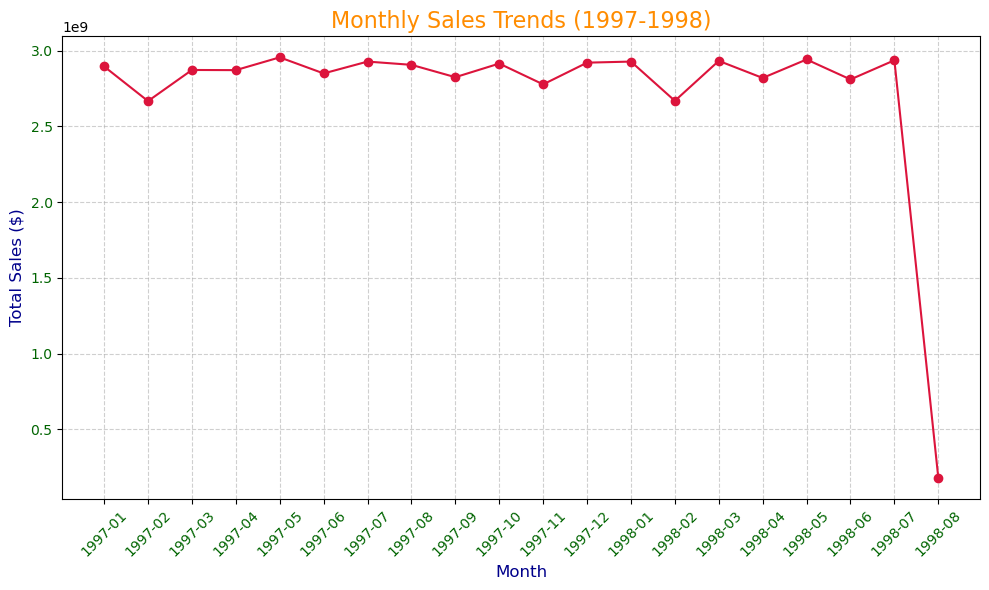

<h3 style='color: darkorange;'>Yearly Sales Trends (All Years)</h3>

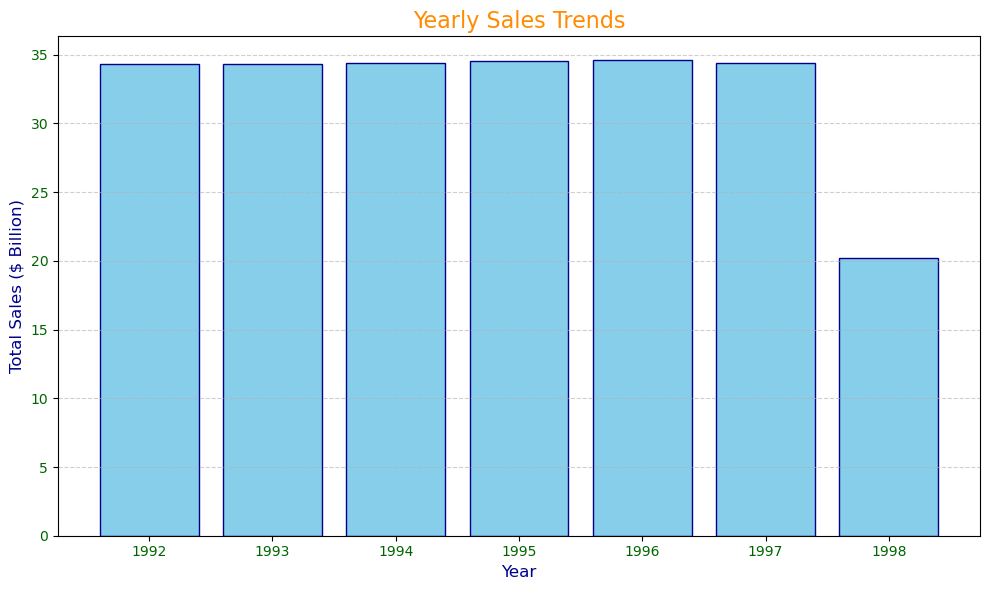

<h2 style='color: darkred;'>Conclusion</h2>

<p style='color: darkblue;'>The report highlights monthly sales trends for 1997-1998 and yearly aggregated trends for all available years. This approach provides a detailed view of recent trends while maintaining an overall perspective on yearly performance.</p>

In [1]:
import logging
import os
from dotenv import load_dotenv
import snowflake.connector
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from IPython.display import display, Markdown

# Load environment variables from .env file
load_dotenv(dotenv_path="/Users/drupa/Desktop/jupyter_notebook_project/Spark-Snowflake-In-JupyterNotebook/.env")

# Set global logging level to WARNING
logging.getLogger("snowflake").setLevel(logging.WARNING)

def get_snowflake_connection():
    retries = 3
    for i in range(retries):
        try:
            conn = snowflake.connector.connect(
                user=os.getenv("SNOWFLAKE_USER"),
                password=os.getenv("SNOWFLAKE_PASSWORD"),
                account="YUB81215.us-west-2",
                warehouse="COMPUTE_WH",
                database="SNOWFLAKE_SAMPLE_DATA",
                schema="TPCH_SF1"
            )
            return conn
        except Exception as ex:
            print(f"Retry {i + 1}: Unable to connect to Snowflake. Error: {ex}")
            time.sleep(2)
    raise Exception("Failed to connect to Snowflake after multiple retries.")

try:
    # Establish Snowflake connection
    conn = get_snowflake_connection()
    
    # Query raw data (excluding O_COMMENT column)
    raw_query = """
        SELECT O_ORDERKEY, O_CUSTKEY, O_ORDERSTATUS, O_TOTALPRICE, O_ORDERDATE, O_ORDERPRIORITY, O_CLERK, O_SHIPPRIORITY
        FROM ORDERS
        LIMIT 5
    """
    raw_data = pd.read_sql(raw_query, conn)

    # Convert raw data to Spark DataFrame
    spark = SparkSession.builder.appName("Retail Analytics").getOrCreate()
    raw_spark_df = spark.createDataFrame(raw_data)

    # Display raw Spark DataFrame
    display(Markdown("<h1 style='color: darkblue;'>Raw Spark DataFrame</h1>"))
    raw_spark_df.show(5, truncate=False)

    # Query sales over time (monthly transformation)
    sales_over_time_query = """
        SELECT TO_CHAR(O_ORDERDATE, 'YYYY-MM') AS ORDER_MONTH, 
               SUM(O_TOTALPRICE) AS TOTAL_SALES
        FROM ORDERS
        GROUP BY ORDER_MONTH
        ORDER BY ORDER_MONTH
    """
    sales_data = pd.read_sql(sales_over_time_query, conn)

    # Convert transformed data to Spark DataFrame
    spark_df = spark.createDataFrame(sales_data)

    # Display transformed Spark DataFrame
    display(Markdown("<h1 style='color: darkblue;'>Transformed Spark DataFrame (Monthly Sales)</h1>"))
    spark_df.show(5, truncate=False)

    # Add year column for bar chart
    sales_data['YEAR'] = sales_data['ORDER_MONTH'].str[:4]
    yearly_sales = sales_data.groupby('YEAR')['TOTAL_SALES'].sum().reset_index()

    # Filter data for the last two years (1997 and 1998) for line chart
    monthly_sales = sales_data[sales_data['ORDER_MONTH'].str.startswith(('1997', '1998'))]

    # Report Title
    display(Markdown("<h1 style='color: darkred;'>Retail Sales Analysis Report</h1>"))

    # Sample DataFrames
    display(Markdown("<h3 style='color: darkblue;'>Sample Data: Sales by Month (1997-1998)</h3>"))
    display(monthly_sales.head())
    
    display(Markdown("<h3 style='color: darkblue;'>Sample Data: Yearly Sales</h3>"))
    display(yearly_sales)

    # Monthly Sales Line Chart
    display(Markdown("<h3 style='color: darkorange;'>Monthly Sales Trends (1997-1998)</h3>"))
    plt.figure(figsize=(10, 6))
    plt.plot(monthly_sales['ORDER_MONTH'], monthly_sales['TOTAL_SALES'], marker='o', linestyle='-', color='crimson')
    plt.title("Monthly Sales Trends (1997-1998)", fontsize=16, color='darkorange')
    plt.xlabel("Month", fontsize=12, color='darkblue')
    plt.ylabel("Total Sales ($)", fontsize=12, color='darkblue')
    plt.xticks(rotation=45, color='darkgreen')
    plt.yticks(color='darkgreen')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
    
    # Yearly Sales Bar Chart
    display(Markdown("<h3 style='color: darkorange;'>Yearly Sales Trends (All Years)</h3>"))
    plt.figure(figsize=(10, 6))
    plt.bar(yearly_sales['YEAR'], yearly_sales['TOTAL_SALES'] / 1e9, color='skyblue', edgecolor='darkblue')
    plt.title("Yearly Sales Trends", fontsize=16, color='darkorange')
    plt.xlabel("Year", fontsize=12, color='darkblue')
    plt.ylabel("Total Sales ($ Billion)", fontsize=12, color='darkblue')
    plt.xticks(color='darkgreen')
    plt.yticks(color='darkgreen')
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
    
    # Conclusion
    display(Markdown("<h2 style='color: darkred;'>Conclusion</h2>"))
    display(Markdown("<p style='color: darkblue;'>The report highlights monthly sales trends for 1997-1998 and yearly aggregated trends for all available years. "
                     "This approach provides a detailed view of recent trends while maintaining an overall perspective on yearly performance.</p>"))

except Exception as ex:
    print("An error occurred:", ex)
finally:
    if 'conn' in locals() and conn:
        conn.close()